In [2]:
import numpy as np
from scipy.optimize import minimize
from mygp import gp, kernel

# setup plotting
import matplotlib.pyplot as pl
%matplotlib inline
import seaborn as sns
palette = sns.color_palette()
sns.set()

In [58]:
def make_params(n_samples, log_A=None, log_l=None, log_wn=None, c=None, mean_params=None, offset=None):
    if n_samples > 1:
        return np.concatenate(([log_A], [log_l], log_wn, [1], c, mean_params, offset))
    elif n_samples == 1:
        return np.concatenate(([log_A], [log_l], [log_wn], mean_params, [offset]))

def neg_log_like(params, mean_func, n_samples, n_mean_params, t, data):
    
    if n_mean_params > 0:
        def make_mean(off): return (lambda x: mean_func(x, off, *mean_params))
    else:
        def make_mean(off): return (lambda x: mean_func(x, off))
    
    if n_samples > 1:
        log_A, log_l, log_wn, c, mean_params, offset = unpack_params(params, n_samples, n_mean_params)  
        k2 = kernel.scale_kernel([scale for scale in c])
        mean = [make_mean(off) for off in offset]
    else:
        log_A, log_l, log_wn, mean_params, offset = unpack_params(params, n_samples, n_mean_params)    
        k2 = None
        mean = make_mean(offset)
   
    k1 = kernel.exp_sq_kernel(np.exp(log_l), np.exp(log_A))
    
    dim = (n_samples > 1) + 1
    g = gp(mean, k1, kernel2=k2, wn=[np.exp(lwn) for lwn in log_wn], dim=dim)
    g.compute(t)
    nll = -g.log_likelihood(data, x=t)
    return nll

def unpack_params(params, n_samples, n_mean_params):
    
    if n_samples > 1:
        lengths = 1, 1, n_samples, n_samples, n_mean_params, n_samples
    elif n_samples == 1:
        lengths = 1, 1, 1, n_mean_params, 1
        
    breaks = [sum(lengths[:i]) for i in range(len(lengths))]
    breaks = np.concatenate((breaks, [len(params)]))
    return [params[breaks[i]:breaks[i+1]] for i in range(len(breaks)-1)]

def print_params(params, n_samples, n_mean_params):
    if n_samples > 1:
        log_A, log_l, log_wn, c, mean_params, offset = unpack_params(params, n_samples, n_mean_params)
    elif n_samples == 1:
        log_A, log_l, log_wn, mean_params, offset = unpack_params(params, n_samples, n_mean_params)
    print('A: ', np.exp(log_A))
    print('l: ', np.exp(log_l))
    print('white noise: ', np.exp(log_wn))
    if n_samples > 1:
        print('scale factors: ', c)
    print('mean parameters: ', mean_params)
    print('offsets: ', offset)

def gauss(t, offset, A, t0, sig):
    return offset + A*np.exp(-((t - t0)**2)/(2*sig*sig))

def no_gauss(t, offset):
    return offset

In [64]:
filename = 'lc3.txt'
y1, y2, y3, t = np.loadtxt(filename)

# starting guesses for minimization
log_A = np.log(100)
log_l = np.log(1)
log_wn = np.log([5, 5, 5])
c = [1, 1]
mean_params = [0, 5, 1]
offset = [0, 0, 0]

bounds = [(None, None), (None, None), (None, None), (1, 1), (None, None), (None, None), (0, np.inf), (0, np.inf), 
          (None, None), (0, np.inf), (0, np.inf), (None, None), (None, None), (None, None)]

p0 = make_params(3, log_A=log_A, log_l=log_l, log_wn=log_wn, c=c, mean_params=mean_params, offset=offset)

# L-BFGS-B minimization with signal
func = lambda p: neg_log_like(p, gauss, 3, 3, t, [y1, y2, y3])
min_params = minimize(func, x0=p0, bounds=bounds, method='L-BFGS-B')
log_likelihood_gauss = -neg_log_like(min_params.x, gauss, 3, 3, t, [y1, y2, y3])

# L-BFGS-B minimization with no signal
p0 = np.concatenate((p0[:7],p0[10:]))
bounds = np.concatenate((bounds[:7],bounds[10:]))
func = lambda p: neg_log_like(p, no_gauss, 3, 0, t, [y1, y2, y3])
log_min_params_no_gauss = minimize(func, x0=p0, bounds=bounds, method='L-BFGS-B')
log_likelihood_no_gauss = -neg_log_like(min_params_no_gauss.x, no_gauss, 3, 0, t, [y1, y2, y3])

def BIC(log_like, n, n_params):
    return np.log(n)*n_params - 2*log_like

BIC_gauss = BIC(log_likelihood_gauss, 3*len(y1), len(p0)+3)
BIC_no_gauss = BIC(log_likelihood_no_gauss, 3*len(y1), len(p0))

# print the best fit parameters for both cases
print('Best Fit Parameters')
print('---------------')
print_params(min_params.x, 3, 3)
print(' ')
print('BIC with gaussian model: {:.2f}'.format(BIC_gauss))
print('BIC without gaussian model: {:.2f}'.format(BIC_no_gauss))
print('delta BIC: {:.2f}'.format(BIC_gauss - BIC_no_gauss))

Best Fit Parameters
---------------
A:  [50.65877692]
l:  [0.16866173]
white noise:  [4.69479181 2.71828183 9.31807594]
scale factors:  [0.22400501 0.97967747 0.87219143]
mean parameters:  [-23.28738298   5.19079249   0.53400263]
offsets:  [26.89806222 32.7315248   9.79119184]
 
BIC with gaussian model: 2319.27
BIC without gaussian model: 2376.04
delta BIC: -56.77


/Users/tgordon/research/gp2d/mygp.py:194: RuntimeWarning: overflow encountered in double_scalars
  self.detK = np.prod(np.diag(self.L))**2


Text(0,0.5,'flux')

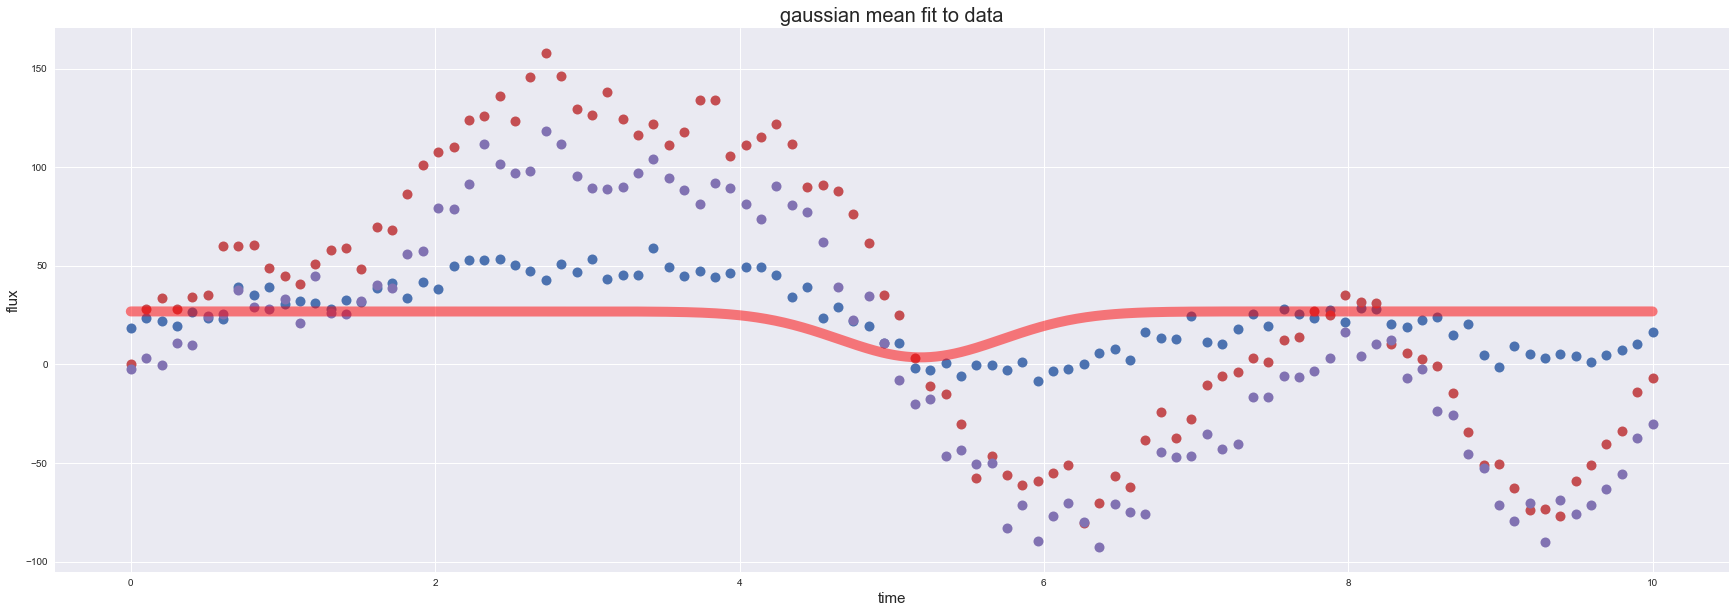

In [51]:
_, _, _, _, mean_params, offset = unpack_params(min_params.x, 3, 3)
tp = np.linspace(min(t), max(t), 1000)

fig = pl.figure(figsize=(30, 10))
pl.plot(t, y1, 'o', alpha=1, color=palette[0], markersize=10)
pl.plot(t, y2, 'o', alpha=1, color=palette[2], markersize=10)
pl.plot(t, y3, 'o', alpha=1, color=palette[3], markersize=10)
pl.plot(tp, gauss(tp, offset[0], *mean_params), linewidth=10, color='r', alpha=0.5)

pl.title('gaussian mean fit to data', size=20)
pl.xlabel('time', size=15)
pl.ylabel('flux', size=15)